In [1]:
#import libraries
import os as os
os.environ['USE_PYGEOS'] = '0'
import matplotlib.pyplot as plt
import osmnx as ox
import geopandas as gpd
import networkx as nx
import shapely as shply
import folium as fm
import rasterio as rio
import elevation as elev
from networkx import shortest_path

In [2]:
#evacuation zone shape files
xl_ev_zones = gpd.read_file('/Users/maxspiegel/Desktop/490GSDS/GitHub/Tsunami-Scenarios/Statewide_Tsunami_Scenarios/Statewide_XL_Tsunami_Inundation_Scenario.shp')
xxl_ev_zones = gpd.read_file('/Users/maxspiegel/Desktop/490GSDS/GitHub/Tsunami-Scenarios/Statewide_Tsunami_Scenarios/Statewide_XXL_Tsunami_Inundation_Scenario.shp')

#critical facilities shape file
critical_facil = gpd.read_file('/Users/maxspiegel/Desktop/490GSDS/final_project/EvacuationBrochure_Data/CriticalFacilities.shp')
#reprojecting
critical_facil = critical_facil.to_crs('EPSG:32610')


In [3]:
#reprojecting ev zones
xxl_ev_zones = xxl_ev_zones.to_crs('EPSG:32610')
xl_ev_zones = xl_ev_zones.to_crs('EPSG:32610')

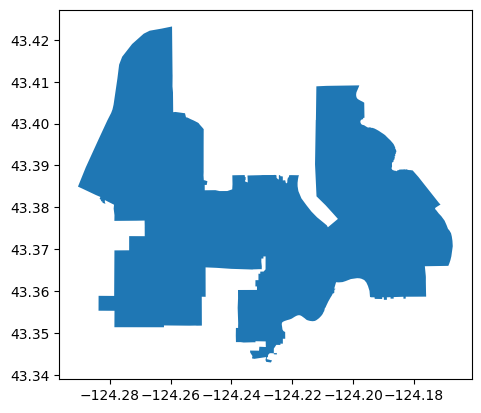

In [4]:
ox.settings.log_console=True
# define the place query for coos bay on osmnx
query = {'city': 'Coos Bay'}

# get the boundaries of the city limits
gdf_coos = ox.geocode_to_gdf(query)
gdf_coos.plot()

coos_bay = gdf_coos.envelope
coos_bay = coos_bay.scale(2,4,2)

In [5]:
coos_bay
coos_bay = coos_bay.to_crs('EPSG:32610')

In [6]:
#checking coos bay data
gdf_coos.head()

,geometry,bbox_north,bbox_south,bbox_east,bbox_west,place_id,osm_type,osm_id,lat,lon,display_name,class,type,importance
0,"POLYGON ((-124.29044 43.38495, -124.28897 43.3...",43.42319,43.342956,-124.167292,-124.290437,298362632,relation,186285,43.367894,-124.217465,"Coos Bay, Coos County, Oregon, 97420, United S...",boundary,administrative,0.656381


In [40]:
#getting coos bay building data
tags = {'building': True}
cb_buildings = ox.geometries_from_place('Coos Bay, Oregon, USA', tags)


/Users/maxspiegel/.gds/lib/python3.10/site-packages/geopandas/tools/clip.py:67: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


<AxesSubplot: >

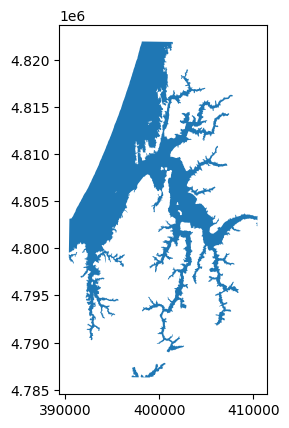

In [8]:
#clipping evacuation zones to coos bay area)
#xxl
clipped_ev_xxl = xxl_ev_zones.clip(coos_bay)

#xl
clipped_ev_xl = xl_ev_zones.clip(coos_bay)

clipped_ev_xl.plot()

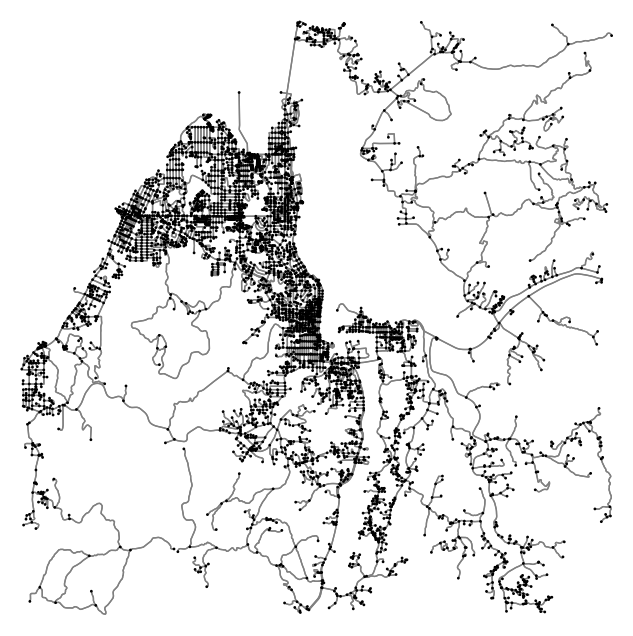

/Users/maxspiegel/.gds/lib/python3.10/site-packages/geopandas/geodataframe.py:2233: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:32610
Right CRS: EPSG:4326

  return geopandas.clip(self, mask=mask, keep_geom_type=keep_geom_type)


In [39]:
#creating coos bay network
lat_lon = (43.3672, -124.2131)
coos_ntwrk = ox.graph_from_point(lat_lon, dist=8000, network_type='walk')
fig, ax = ox.plot_graph(coos_ntwrk, bgcolor='white', node_color='black', edge_color='grey', node_size=4)

node_graph = ox.graph_to_gdfs(coos_ntwrk, nodes=True, edges=False)
node_graph = node_graph.to_crs('EPSG:32610')
edge_graph = ox.graph_to_gdfs(coos_ntwrk, nodes=False, edges=True)
edge_graph = edge_graph.to_crs('EPSG:32610')
node_clip = node_graph.clip(gdf_coos)


<AxesSubplot: >

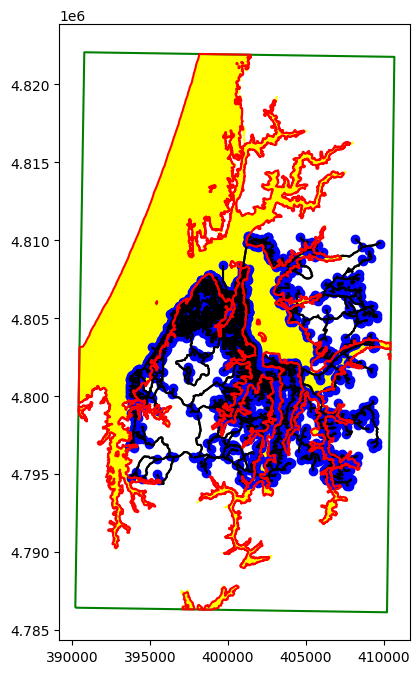

In [17]:
#graphing the network with the evacuation zones, and coos bay city limits
fig, ax = plt.subplots(figsize=(8, 8))
clipped_ev_xxl.plot(ax=ax, color= "yellow")
node_graph.plot(ax=ax, color= "blue")
edge_graph.plot(ax=ax, color="black")
coos_bay.boundary.plot(ax=ax, color="green")
clipped_ev_xl.boundary.plot(ax=ax, color = 'red')

In [11]:
#assembly areas and higher ground shape files + reproject
assembly_areas =gpd.read_file('/Users/maxspiegel/Desktop/490GSDS/GitHub/Tsunami-Scenarios/Assembly_Areas.shp')
assembly_areas= assembly_areas.to_crs('EPSG:32610')

higher_ground = gpd.read_file('/Users/maxspiegel/Desktop/490GSDS/GitHub/Tsunami-Scenarios/OutsideHazardArea_GreenHighGround.shp')
higher_ground= higher_ground.to_crs('EPSG:32610')

In [12]:
#clipping critical facil to coos bay area
crit_clip = critical_facil.clip(coos_bay)
crit_clip

,Id,Site_Type,Name,POINT_X,POINT_Y,geometry
572,0,BRIDGE,"Beaver Creek, Hwy 35 EB",-124.235726,43.227371,POINT (399648.580 4786806.230)
573,0,BRIDGE,"Beaver Creek, Hwy 35 WB",-124.235962,43.227415,POINT (399629.487 4786811.400)
606,0,BRIDGE,"South Slough, County Rd 68",-124.319677,43.276195,POINT (392916.637 4792332.620)
570,0,BRIDGE,"Davis Slough, Hwy 35 EB",-124.226242,43.288484,POINT (400518.331 4793581.845)
571,0,BRIDGE,Hwy 35 over COR,-124.225056,43.245731,POINT (400544.944 4788832.536)
...,...,...,...,...,...,...
638,0,BRIDGE,WILLANCH CREEK WEST BRIDGE,-124.155940,43.410880,POINT (406409.980 4807093.370)
641,0,BRIDGE,WILLANCH CREEK BRIDGE @ MP 3.50 WILLANCH WAY,-124.132003,43.417508,POINT (408357.996 4807802.849)
592,0,BRIDGE,"Blackmoor/Larson Creek, County Rd 248G",-124.139034,43.480757,POINT (407884.868 4814834.981)
654,0,BRIDGE,"Shutter Creek, Larsen Ranch Rd.",-124.154958,43.538323,POINT (406685.759 4821245.937)


<AxesSubplot: >

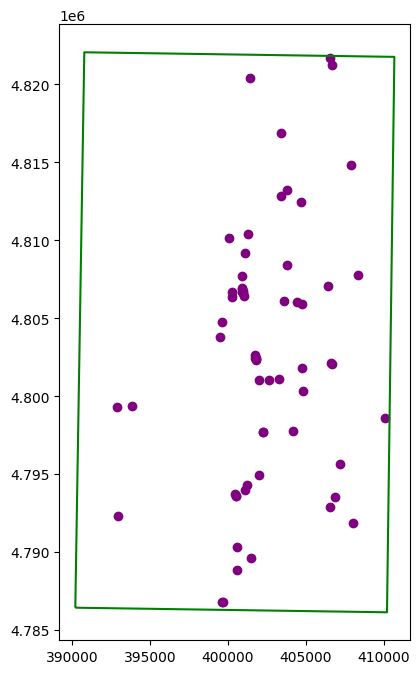

In [13]:
#filtering out for just the bridges, plotting 
bridge_crit = crit_clip[crit_clip['Site_Type'] == 'BRIDGE']

fig, ax = plt.subplots(figsize=(12, 8))

coos_bay.boundary.plot(ax=ax, color="green")
bridge_crit.plot(ax=ax, color= 'purple')

In [34]:
#making the nodes an array
array_nodes = node_graph.index.values

In [52]:
#attempting to use shortest path syntax from lab to find shortest paths 
graph_proj= ox.project_graph(coos_ntwrk, to_crs=None)

In [53]:
#tuple index out of raange?
route = nx.shortest_path(G=graph_proj, source=None, target=None, weight=None, method='dijkstra')
length = nx.shortest_path_length(G=graph_proj, source=None, target=None, weight='length', method='dijkstra')

IndexError: tuple index out of range